In [1]:
import sys
import time
import torch
from torch.utils.data import TensorDataset
import numpy as np
from matplotlib import pyplot as plt
import logging

sys.path.append("../../")
import manifold_flow as mf
from manifold_flow import transforms, utils, flows, distributions, training, timer
from manifold_flow import nn as nn_

%matplotlib inline

logging.basicConfig(
    format="%(asctime)-5.5s %(name)-30.30s %(levelname)-7.7s %(message)s",
    datefmt="%H:%M",
    level=logging.DEBUG,
)
logger = logging.getLogger(__name__)
# Output of all other modules (e.g. matplotlib)
for key in logging.Logger.manager.loggerDict:
    if "manifold_flow" not in key:
        logging.getLogger(key).setLevel(logging.WARNING)


## Timing function

In [2]:
def make_data(dim, n=100):
    return torch.randn(dim*n).view(n, dim)

In [3]:
def make_model(xdim, blocks=5, ldim=1):
    trf = flows.vector_transforms.create_transform(
        dim=xdim,
        flow_steps=5,
        linear_transform_type="permutation",
        base_transform_type="affine-coupling",
        hidden_features=20,
        num_transform_blocks=blocks,
        dropout_probability=0.,
        use_batch_norm=False
    )
    return trf

In [4]:
def time_logdet(model, data, repeats=3):
    times = []
    for _ in range(repeats):
        time_before = time.time()
        
        _ = model(data, full_jacobian=False)
        
        time_after = time.time()
        
        print(time_after-time_before, "s")
        times.append(time_after-time_before)
    return np.mean(times), np.std(times)

In [5]:
def time_jacobian(model, data, repeats=3):
    times = []
    for _ in range(repeats):
        timer.reset()
        time_before = time.time()
        
        _ = model(data, full_jacobian=True)
        
        time_after = time.time()
        timer.report()
        
        print(time_after-time_before, "s")
        times.append(time_after-time_before)
    return np.mean(times), np.std(times)

In [6]:
def run(xdim, blocks=5, jacobian=True):
    data = make_data(xdim)
    data.requires_grad = True
    model = make_model(xdim, blocks)
    if jacobian:
        return time_jacobian(model, data)
    else:
        return time_logdet(model, data)

## Go!

In [7]:
blocks = [1,2,5,10]
xdims = [2,5,10,20,50,100]

jacobian_means = []
jacobian_stds = []
det_means = []
det_stds = []

for block in blocks:
    for xdim in xdims:
        print("blocks = {}, xdim = {}".format(block, xdim))
        mean_jac, std_jac = run(xdim, block, True)
        mean_det, std_det = run(xdim, block, False)
        jacobian_means.append(mean_jac)
        jacobian_stds.append(std_jac)
        det_means.append(mean_det)
        det_stds.append(std_det)

blocks = np.asarray(blocks)
xdims = np.asarray(xdims)
jacobian_means = np.asarray(jacobian_means).reshape(len(blocks), -1)
jacobian_stds = np.asarray(jacobian_stds).reshape(len(blocks), -1)
det_means = np.asarray(det_means).reshape(len(blocks), -1)
det_stds = np.asarray(det_stds).reshape(len(blocks), -1)


16:18 manifold_flow.timer            INFO    Timer:
16:18 manifold_flow.timer            INFO                  Jacobian permutation:   0:00:00.00
16:18 manifold_flow.timer            INFO               Jacobian multiplication:   0:00:00.00
16:18 manifold_flow.timer            INFO           Jacobian coupling transform:   0:00:00.08
16:18 manifold_flow.timer            INFO    Timer:
16:18 manifold_flow.timer            INFO                  Jacobian permutation:   0:00:00.00
16:18 manifold_flow.timer            INFO               Jacobian multiplication:   0:00:00.00
16:18 manifold_flow.timer            INFO           Jacobian coupling transform:   0:00:00.09


blocks = 1, xdim = 2
0.08352422714233398 s
0.09737682342529297 s


16:18 manifold_flow.timer            INFO    Timer:
16:18 manifold_flow.timer            INFO                  Jacobian permutation:   0:00:00.00
16:18 manifold_flow.timer            INFO               Jacobian multiplication:   0:00:00.00
16:18 manifold_flow.timer            INFO           Jacobian coupling transform:   0:00:00.11


0.11916899681091309 s
0.005820035934448242 s
0.0026819705963134766 s
0.003522157669067383 s
blocks = 1, xdim = 5


16:18 manifold_flow.timer            INFO    Timer:
16:18 manifold_flow.timer            INFO                  Jacobian permutation:   0:00:00.00
16:18 manifold_flow.timer            INFO               Jacobian multiplication:   0:00:00.00
16:18 manifold_flow.timer            INFO           Jacobian coupling transform:   0:00:00.18
16:18 manifold_flow.timer            INFO    Timer:
16:18 manifold_flow.timer            INFO                  Jacobian permutation:   0:00:00.00
16:18 manifold_flow.timer            INFO               Jacobian multiplication:   0:00:00.00
16:18 manifold_flow.timer            INFO           Jacobian coupling transform:   0:00:00.18


0.18360304832458496 s
0.1814100742340088 s


16:18 manifold_flow.timer            INFO    Timer:
16:18 manifold_flow.timer            INFO                  Jacobian permutation:   0:00:00.00
16:18 manifold_flow.timer            INFO               Jacobian multiplication:   0:00:00.00
16:18 manifold_flow.timer            INFO           Jacobian coupling transform:   0:00:00.18


0.18370366096496582 s
0.0022878646850585938 s
0.004210948944091797 s
0.002357006072998047 s
blocks = 1, xdim = 10


16:18 manifold_flow.timer            INFO    Timer:
16:18 manifold_flow.timer            INFO                  Jacobian permutation:   0:00:00.00
16:18 manifold_flow.timer            INFO               Jacobian multiplication:   0:00:00.00
16:18 manifold_flow.timer            INFO           Jacobian coupling transform:   0:00:00.33


0.33379697799682617 s


16:18 manifold_flow.timer            INFO    Timer:
16:18 manifold_flow.timer            INFO                  Jacobian permutation:   0:00:00.00
16:18 manifold_flow.timer            INFO               Jacobian multiplication:   0:00:00.00
16:18 manifold_flow.timer            INFO           Jacobian coupling transform:   0:00:00.33


0.3332860469818115 s


16:18 manifold_flow.timer            INFO    Timer:
16:18 manifold_flow.timer            INFO                  Jacobian permutation:   0:00:00.00
16:18 manifold_flow.timer            INFO               Jacobian multiplication:   0:00:00.00
16:18 manifold_flow.timer            INFO           Jacobian coupling transform:   0:00:00.34


0.34180474281311035 s
0.003753185272216797 s
0.002196073532104492 s
0.0020558834075927734 s
blocks = 1, xdim = 20


16:18 manifold_flow.timer            INFO    Timer:
16:18 manifold_flow.timer            INFO                  Jacobian permutation:   0:00:00.00
16:18 manifold_flow.timer            INFO               Jacobian multiplication:   0:00:00.00
16:18 manifold_flow.timer            INFO           Jacobian coupling transform:   0:00:00.62


0.6246089935302734 s


16:18 manifold_flow.timer            INFO    Timer:
16:18 manifold_flow.timer            INFO                  Jacobian permutation:   0:00:00.00
16:18 manifold_flow.timer            INFO               Jacobian multiplication:   0:00:00.00
16:18 manifold_flow.timer            INFO           Jacobian coupling transform:   0:00:00.72


0.7267129421234131 s


16:18 manifold_flow.timer            INFO    Timer:
16:18 manifold_flow.timer            INFO                  Jacobian permutation:   0:00:00.00
16:18 manifold_flow.timer            INFO               Jacobian multiplication:   0:00:00.00
16:18 manifold_flow.timer            INFO           Jacobian coupling transform:   0:00:00.66


0.6657531261444092 s
0.003556966781616211 s
0.004156827926635742 s
0.004164218902587891 s
blocks = 1, xdim = 50


16:18 manifold_flow.timer            INFO    Timer:
16:18 manifold_flow.timer            INFO                  Jacobian permutation:   0:00:00.01
16:18 manifold_flow.timer            INFO               Jacobian multiplication:   0:00:00.00
16:18 manifold_flow.timer            INFO           Jacobian coupling transform:   0:00:01.58


1.5925118923187256 s


16:18 manifold_flow.timer            INFO    Timer:
16:18 manifold_flow.timer            INFO                  Jacobian permutation:   0:00:00.00
16:18 manifold_flow.timer            INFO               Jacobian multiplication:   0:00:00.00
16:18 manifold_flow.timer            INFO           Jacobian coupling transform:   0:00:01.65


1.665160894393921 s


16:18 manifold_flow.timer            INFO    Timer:
16:18 manifold_flow.timer            INFO                  Jacobian permutation:   0:00:00.00
16:18 manifold_flow.timer            INFO               Jacobian multiplication:   0:00:00.00
16:18 manifold_flow.timer            INFO           Jacobian coupling transform:   0:00:01.70


1.709374189376831 s
0.003690004348754883 s
0.003271818161010742 s
0.004325151443481445 s
blocks = 1, xdim = 100


16:18 manifold_flow.timer            INFO    Timer:
16:18 manifold_flow.timer            INFO                  Jacobian permutation:   0:00:00.02
16:18 manifold_flow.timer            INFO               Jacobian multiplication:   0:00:00.02
16:18 manifold_flow.timer            INFO           Jacobian coupling transform:   0:00:03.24


3.295037031173706 s


16:18 manifold_flow.timer            INFO    Timer:
16:18 manifold_flow.timer            INFO                  Jacobian permutation:   0:00:00.01
16:18 manifold_flow.timer            INFO               Jacobian multiplication:   0:00:00.02
16:18 manifold_flow.timer            INFO           Jacobian coupling transform:   0:00:03.83


3.8704590797424316 s


16:18 manifold_flow.timer            INFO    Timer:
16:18 manifold_flow.timer            INFO                  Jacobian permutation:   0:00:00.01
16:18 manifold_flow.timer            INFO               Jacobian multiplication:   0:00:00.02
16:18 manifold_flow.timer            INFO           Jacobian coupling transform:   0:00:02.90
16:18 manifold_flow.timer            INFO    Timer:
16:18 manifold_flow.timer            INFO                  Jacobian permutation:   0:00:00.00
16:18 manifold_flow.timer            INFO               Jacobian multiplication:   0:00:00.00
16:18 manifold_flow.timer            INFO           Jacobian coupling transform:   0:00:00.09


2.9337828159332275 s
0.004545688629150391 s
0.011760950088500977 s
0.005335092544555664 s
blocks = 2, xdim = 2
0.0953831672668457 s


16:18 manifold_flow.timer            INFO    Timer:
16:18 manifold_flow.timer            INFO                  Jacobian permutation:   0:00:00.00
16:18 manifold_flow.timer            INFO               Jacobian multiplication:   0:00:00.00
16:18 manifold_flow.timer            INFO           Jacobian coupling transform:   0:00:00.11
16:18 manifold_flow.timer            INFO    Timer:
16:18 manifold_flow.timer            INFO                  Jacobian permutation:   0:00:00.00
16:18 manifold_flow.timer            INFO               Jacobian multiplication:   0:00:00.00
16:18 manifold_flow.timer            INFO           Jacobian coupling transform:   0:00:00.10


0.11385989189147949 s
0.10783267021179199 s
0.002073049545288086 s
0.0037698745727539062 s
0.00452423095703125 s
blocks = 2, xdim = 5


16:18 manifold_flow.timer            INFO    Timer:
16:18 manifold_flow.timer            INFO                  Jacobian permutation:   0:00:00.00
16:18 manifold_flow.timer            INFO               Jacobian multiplication:   0:00:00.00
16:18 manifold_flow.timer            INFO           Jacobian coupling transform:   0:00:00.24


0.24727201461791992 s


16:18 manifold_flow.timer            INFO    Timer:
16:18 manifold_flow.timer            INFO                  Jacobian permutation:   0:00:00.00
16:18 manifold_flow.timer            INFO               Jacobian multiplication:   0:00:00.00
16:18 manifold_flow.timer            INFO           Jacobian coupling transform:   0:00:00.22


0.22780275344848633 s


16:18 manifold_flow.timer            INFO    Timer:
16:18 manifold_flow.timer            INFO                  Jacobian permutation:   0:00:00.00
16:18 manifold_flow.timer            INFO               Jacobian multiplication:   0:00:00.00
16:18 manifold_flow.timer            INFO           Jacobian coupling transform:   0:00:00.21


0.21849489212036133 s
0.0021979808807373047 s
0.003932952880859375 s
0.0024347305297851562 s
blocks = 2, xdim = 10


16:18 manifold_flow.timer            INFO    Timer:
16:18 manifold_flow.timer            INFO                  Jacobian permutation:   0:00:00.00
16:18 manifold_flow.timer            INFO               Jacobian multiplication:   0:00:00.00
16:18 manifold_flow.timer            INFO           Jacobian coupling transform:   0:00:00.38


0.38439512252807617 s


16:18 manifold_flow.timer            INFO    Timer:
16:18 manifold_flow.timer            INFO                  Jacobian permutation:   0:00:00.00
16:18 manifold_flow.timer            INFO               Jacobian multiplication:   0:00:00.00
16:18 manifold_flow.timer            INFO           Jacobian coupling transform:   0:00:00.40


0.40688490867614746 s


16:18 manifold_flow.timer            INFO    Timer:
16:18 manifold_flow.timer            INFO                  Jacobian permutation:   0:00:00.00
16:18 manifold_flow.timer            INFO               Jacobian multiplication:   0:00:00.00
16:18 manifold_flow.timer            INFO           Jacobian coupling transform:   0:00:00.42


0.4224121570587158 s
0.002405881881713867 s
0.003061056137084961 s
0.002574920654296875 s
blocks = 2, xdim = 20


16:18 manifold_flow.timer            INFO    Timer:
16:18 manifold_flow.timer            INFO                  Jacobian permutation:   0:00:00.00
16:18 manifold_flow.timer            INFO               Jacobian multiplication:   0:00:00.00
16:18 manifold_flow.timer            INFO           Jacobian coupling transform:   0:00:00.77


0.7776477336883545 s


16:18 manifold_flow.timer            INFO    Timer:
16:18 manifold_flow.timer            INFO                  Jacobian permutation:   0:00:00.00
16:18 manifold_flow.timer            INFO               Jacobian multiplication:   0:00:00.00
16:18 manifold_flow.timer            INFO           Jacobian coupling transform:   0:00:00.76


0.7658109664916992 s


16:18 manifold_flow.timer            INFO    Timer:
16:18 manifold_flow.timer            INFO                  Jacobian permutation:   0:00:00.00
16:18 manifold_flow.timer            INFO               Jacobian multiplication:   0:00:00.00
16:18 manifold_flow.timer            INFO           Jacobian coupling transform:   0:00:00.84


0.8438889980316162 s
0.0036017894744873047 s
0.003888845443725586 s
0.0031130313873291016 s
blocks = 2, xdim = 50


16:18 manifold_flow.timer            INFO    Timer:
16:18 manifold_flow.timer            INFO                  Jacobian permutation:   0:00:00.01
16:18 manifold_flow.timer            INFO               Jacobian multiplication:   0:00:00.01
16:18 manifold_flow.timer            INFO           Jacobian coupling transform:   0:00:02.03


2.051514148712158 s


16:18 manifold_flow.timer            INFO    Timer:
16:18 manifold_flow.timer            INFO                  Jacobian permutation:   0:00:00.00
16:18 manifold_flow.timer            INFO               Jacobian multiplication:   0:00:00.00
16:18 manifold_flow.timer            INFO           Jacobian coupling transform:   0:00:02.10


2.1101109981536865 s


16:18 manifold_flow.timer            INFO    Timer:
16:18 manifold_flow.timer            INFO                  Jacobian permutation:   0:00:00.00
16:18 manifold_flow.timer            INFO               Jacobian multiplication:   0:00:00.00
16:18 manifold_flow.timer            INFO           Jacobian coupling transform:   0:00:02.13


2.1403839588165283 s
0.011216163635253906 s
0.005563259124755859 s
0.009386062622070312 s
blocks = 2, xdim = 100


16:18 manifold_flow.timer            INFO    Timer:
16:18 manifold_flow.timer            INFO                  Jacobian permutation:   0:00:00.02
16:18 manifold_flow.timer            INFO               Jacobian multiplication:   0:00:00.02
16:18 manifold_flow.timer            INFO           Jacobian coupling transform:   0:00:03.65


3.706711769104004 s


16:18 manifold_flow.timer            INFO    Timer:
16:18 manifold_flow.timer            INFO                  Jacobian permutation:   0:00:00.01
16:18 manifold_flow.timer            INFO               Jacobian multiplication:   0:00:00.02
16:18 manifold_flow.timer            INFO           Jacobian coupling transform:   0:00:03.61


3.6450891494750977 s


16:19 manifold_flow.timer            INFO    Timer:
16:19 manifold_flow.timer            INFO                  Jacobian permutation:   0:00:00.01
16:19 manifold_flow.timer            INFO               Jacobian multiplication:   0:00:00.02
16:19 manifold_flow.timer            INFO           Jacobian coupling transform:   0:00:03.76
16:19 manifold_flow.timer            INFO    Timer:
16:19 manifold_flow.timer            INFO                  Jacobian permutation:   0:00:00.00
16:19 manifold_flow.timer            INFO               Jacobian multiplication:   0:00:00.00
16:19 manifold_flow.timer            INFO           Jacobian coupling transform:   0:00:00.13


3.8012211322784424 s
0.009644031524658203 s
0.004812002182006836 s
0.00540614128112793 s
blocks = 5, xdim = 2
0.13636183738708496 s


16:19 manifold_flow.timer            INFO    Timer:
16:19 manifold_flow.timer            INFO                  Jacobian permutation:   0:00:00.00
16:19 manifold_flow.timer            INFO               Jacobian multiplication:   0:00:00.00
16:19 manifold_flow.timer            INFO           Jacobian coupling transform:   0:00:00.14
16:19 manifold_flow.timer            INFO    Timer:
16:19 manifold_flow.timer            INFO                  Jacobian permutation:   0:00:00.00
16:19 manifold_flow.timer            INFO               Jacobian multiplication:   0:00:00.00
16:19 manifold_flow.timer            INFO           Jacobian coupling transform:   0:00:00.13


0.14475393295288086 s
0.13889098167419434 s
0.005072116851806641 s
0.00385284423828125 s
0.0056438446044921875 s
blocks = 5, xdim = 5


16:19 manifold_flow.timer            INFO    Timer:
16:19 manifold_flow.timer            INFO                  Jacobian permutation:   0:00:00.00
16:19 manifold_flow.timer            INFO               Jacobian multiplication:   0:00:00.00
16:19 manifold_flow.timer            INFO           Jacobian coupling transform:   0:00:00.30


0.3011460304260254 s


16:19 manifold_flow.timer            INFO    Timer:
16:19 manifold_flow.timer            INFO                  Jacobian permutation:   0:00:00.00
16:19 manifold_flow.timer            INFO               Jacobian multiplication:   0:00:00.00
16:19 manifold_flow.timer            INFO           Jacobian coupling transform:   0:00:00.30


0.3088979721069336 s


16:19 manifold_flow.timer            INFO    Timer:
16:19 manifold_flow.timer            INFO                  Jacobian permutation:   0:00:00.00
16:19 manifold_flow.timer            INFO               Jacobian multiplication:   0:00:00.00
16:19 manifold_flow.timer            INFO           Jacobian coupling transform:   0:00:00.30


0.3085019588470459 s
0.0032219886779785156 s
0.004952669143676758 s
0.0038628578186035156 s
blocks = 5, xdim = 10


16:19 manifold_flow.timer            INFO    Timer:
16:19 manifold_flow.timer            INFO                  Jacobian permutation:   0:00:00.00
16:19 manifold_flow.timer            INFO               Jacobian multiplication:   0:00:00.00
16:19 manifold_flow.timer            INFO           Jacobian coupling transform:   0:00:00.56


0.5659351348876953 s


16:19 manifold_flow.timer            INFO    Timer:
16:19 manifold_flow.timer            INFO                  Jacobian permutation:   0:00:00.00
16:19 manifold_flow.timer            INFO               Jacobian multiplication:   0:00:00.00
16:19 manifold_flow.timer            INFO           Jacobian coupling transform:   0:00:00.57


0.5751268863677979 s


16:19 manifold_flow.timer            INFO    Timer:
16:19 manifold_flow.timer            INFO                  Jacobian permutation:   0:00:00.00
16:19 manifold_flow.timer            INFO               Jacobian multiplication:   0:00:00.00
16:19 manifold_flow.timer            INFO           Jacobian coupling transform:   0:00:00.58


0.5832278728485107 s
0.005513906478881836 s
0.003813028335571289 s
0.0036420822143554688 s
blocks = 5, xdim = 20


16:19 manifold_flow.timer            INFO    Timer:
16:19 manifold_flow.timer            INFO                  Jacobian permutation:   0:00:00.00
16:19 manifold_flow.timer            INFO               Jacobian multiplication:   0:00:00.00
16:19 manifold_flow.timer            INFO           Jacobian coupling transform:   0:00:01.09


1.098478078842163 s


16:19 manifold_flow.timer            INFO    Timer:
16:19 manifold_flow.timer            INFO                  Jacobian permutation:   0:00:00.00
16:19 manifold_flow.timer            INFO               Jacobian multiplication:   0:00:00.00
16:19 manifold_flow.timer            INFO           Jacobian coupling transform:   0:00:01.08


1.0915980339050293 s


16:19 manifold_flow.timer            INFO    Timer:
16:19 manifold_flow.timer            INFO                  Jacobian permutation:   0:00:00.00
16:19 manifold_flow.timer            INFO               Jacobian multiplication:   0:00:00.00
16:19 manifold_flow.timer            INFO           Jacobian coupling transform:   0:00:01.09


1.094709873199463 s
0.00569915771484375 s
0.004243135452270508 s
0.004157304763793945 s
blocks = 5, xdim = 50


16:19 manifold_flow.timer            INFO    Timer:
16:19 manifold_flow.timer            INFO                  Jacobian permutation:   0:00:00.01
16:19 manifold_flow.timer            INFO               Jacobian multiplication:   0:00:00.00
16:19 manifold_flow.timer            INFO           Jacobian coupling transform:   0:00:02.80


2.816087245941162 s


16:19 manifold_flow.timer            INFO    Timer:
16:19 manifold_flow.timer            INFO                  Jacobian permutation:   0:00:00.00
16:19 manifold_flow.timer            INFO               Jacobian multiplication:   0:00:00.00
16:19 manifold_flow.timer            INFO           Jacobian coupling transform:   0:00:02.78


2.799069881439209 s


16:19 manifold_flow.timer            INFO    Timer:
16:19 manifold_flow.timer            INFO                  Jacobian permutation:   0:00:00.00
16:19 manifold_flow.timer            INFO               Jacobian multiplication:   0:00:00.00
16:19 manifold_flow.timer            INFO           Jacobian coupling transform:   0:00:02.75


2.760125160217285 s
0.007408857345581055 s
0.006548881530761719 s
0.004986286163330078 s
blocks = 5, xdim = 100


16:19 manifold_flow.timer            INFO    Timer:
16:19 manifold_flow.timer            INFO                  Jacobian permutation:   0:00:00.02
16:19 manifold_flow.timer            INFO               Jacobian multiplication:   0:00:00.04
16:19 manifold_flow.timer            INFO           Jacobian coupling transform:   0:00:06.33


6.405316114425659 s


16:19 manifold_flow.timer            INFO    Timer:
16:19 manifold_flow.timer            INFO                  Jacobian permutation:   0:00:00.01
16:19 manifold_flow.timer            INFO               Jacobian multiplication:   0:00:00.02
16:19 manifold_flow.timer            INFO           Jacobian coupling transform:   0:00:05.42


5.4495930671691895 s


16:19 manifold_flow.timer            INFO    Timer:
16:19 manifold_flow.timer            INFO                  Jacobian permutation:   0:00:00.01
16:19 manifold_flow.timer            INFO               Jacobian multiplication:   0:00:00.03
16:19 manifold_flow.timer            INFO           Jacobian coupling transform:   0:00:06.56


6.612019062042236 s
0.006992816925048828 s
0.007803916931152344 s
0.010083913803100586 s
blocks = 10, xdim = 2


16:19 manifold_flow.timer            INFO    Timer:
16:19 manifold_flow.timer            INFO                  Jacobian permutation:   0:00:00.00
16:19 manifold_flow.timer            INFO               Jacobian multiplication:   0:00:00.00
16:19 manifold_flow.timer            INFO           Jacobian coupling transform:   0:00:00.21


0.2168121337890625 s


16:19 manifold_flow.timer            INFO    Timer:
16:19 manifold_flow.timer            INFO                  Jacobian permutation:   0:00:00.00
16:19 manifold_flow.timer            INFO               Jacobian multiplication:   0:00:00.00
16:19 manifold_flow.timer            INFO           Jacobian coupling transform:   0:00:00.20


0.20879292488098145 s


16:19 manifold_flow.timer            INFO    Timer:
16:19 manifold_flow.timer            INFO                  Jacobian permutation:   0:00:00.00
16:19 manifold_flow.timer            INFO               Jacobian multiplication:   0:00:00.00
16:19 manifold_flow.timer            INFO           Jacobian coupling transform:   0:00:00.30


0.30802106857299805 s
0.005605220794677734 s
0.005433082580566406 s
0.005471944808959961 s
blocks = 10, xdim = 5


16:19 manifold_flow.timer            INFO    Timer:
16:19 manifold_flow.timer            INFO                  Jacobian permutation:   0:00:00.00
16:19 manifold_flow.timer            INFO               Jacobian multiplication:   0:00:00.00
16:19 manifold_flow.timer            INFO           Jacobian coupling transform:   0:00:00.46


0.4662330150604248 s


16:19 manifold_flow.timer            INFO    Timer:
16:19 manifold_flow.timer            INFO                  Jacobian permutation:   0:00:00.00
16:19 manifold_flow.timer            INFO               Jacobian multiplication:   0:00:00.00
16:19 manifold_flow.timer            INFO           Jacobian coupling transform:   0:00:00.59


0.5971980094909668 s


16:19 manifold_flow.timer            INFO    Timer:
16:19 manifold_flow.timer            INFO                  Jacobian permutation:   0:00:00.00
16:19 manifold_flow.timer            INFO               Jacobian multiplication:   0:00:00.00
16:19 manifold_flow.timer            INFO           Jacobian coupling transform:   0:00:00.48


0.4837651252746582 s
0.007214069366455078 s
0.0066661834716796875 s
0.005874156951904297 s
blocks = 10, xdim = 10


16:19 manifold_flow.timer            INFO    Timer:
16:19 manifold_flow.timer            INFO                  Jacobian permutation:   0:00:00.00
16:19 manifold_flow.timer            INFO               Jacobian multiplication:   0:00:00.00
16:19 manifold_flow.timer            INFO           Jacobian coupling transform:   0:00:00.87


0.8805670738220215 s


16:19 manifold_flow.timer            INFO    Timer:
16:19 manifold_flow.timer            INFO                  Jacobian permutation:   0:00:00.00
16:19 manifold_flow.timer            INFO               Jacobian multiplication:   0:00:00.00
16:19 manifold_flow.timer            INFO           Jacobian coupling transform:   0:00:00.89


0.9023680686950684 s


16:19 manifold_flow.timer            INFO    Timer:
16:19 manifold_flow.timer            INFO                  Jacobian permutation:   0:00:00.00
16:19 manifold_flow.timer            INFO               Jacobian multiplication:   0:00:00.00
16:19 manifold_flow.timer            INFO           Jacobian coupling transform:   0:00:01.19


1.2053940296173096 s
0.012698888778686523 s
0.010982990264892578 s
0.01105809211730957 s
blocks = 10, xdim = 20


16:19 manifold_flow.timer            INFO    Timer:
16:19 manifold_flow.timer            INFO                  Jacobian permutation:   0:00:00.00
16:19 manifold_flow.timer            INFO               Jacobian multiplication:   0:00:00.00
16:19 manifold_flow.timer            INFO           Jacobian coupling transform:   0:00:02.07


2.0841190814971924 s


16:19 manifold_flow.timer            INFO    Timer:
16:19 manifold_flow.timer            INFO                  Jacobian permutation:   0:00:00.00
16:19 manifold_flow.timer            INFO               Jacobian multiplication:   0:00:00.00
16:19 manifold_flow.timer            INFO           Jacobian coupling transform:   0:00:02.15


2.1671080589294434 s


16:19 manifold_flow.timer            INFO    Timer:
16:19 manifold_flow.timer            INFO                  Jacobian permutation:   0:00:00.00
16:19 manifold_flow.timer            INFO               Jacobian multiplication:   0:00:00.00
16:19 manifold_flow.timer            INFO           Jacobian coupling transform:   0:00:01.94


1.947511911392212 s
0.00857400894165039 s
0.007154226303100586 s
0.00612187385559082 s
blocks = 10, xdim = 50


16:19 manifold_flow.timer            INFO    Timer:
16:19 manifold_flow.timer            INFO                  Jacobian permutation:   0:00:00.01
16:19 manifold_flow.timer            INFO               Jacobian multiplication:   0:00:00.00
16:19 manifold_flow.timer            INFO           Jacobian coupling transform:   0:00:05.13


5.151397228240967 s


16:19 manifold_flow.timer            INFO    Timer:
16:19 manifold_flow.timer            INFO                  Jacobian permutation:   0:00:00.00
16:19 manifold_flow.timer            INFO               Jacobian multiplication:   0:00:00.00
16:19 manifold_flow.timer            INFO           Jacobian coupling transform:   0:00:05.12


5.135387897491455 s


16:20 manifold_flow.timer            INFO    Timer:
16:20 manifold_flow.timer            INFO                  Jacobian permutation:   0:00:00.00
16:20 manifold_flow.timer            INFO               Jacobian multiplication:   0:00:00.00
16:20 manifold_flow.timer            INFO           Jacobian coupling transform:   0:00:05.87


5.885128021240234 s
0.009337902069091797 s
0.01015925407409668 s
0.006940126419067383 s
blocks = 10, xdim = 100


16:20 manifold_flow.timer            INFO    Timer:
16:20 manifold_flow.timer            INFO                  Jacobian permutation:   0:00:00.02
16:20 manifold_flow.timer            INFO               Jacobian multiplication:   0:00:00.03
16:20 manifold_flow.timer            INFO           Jacobian coupling transform:   0:00:09.87


9.931564092636108 s


16:20 manifold_flow.timer            INFO    Timer:
16:20 manifold_flow.timer            INFO                  Jacobian permutation:   0:00:00.01
16:20 manifold_flow.timer            INFO               Jacobian multiplication:   0:00:00.02
16:20 manifold_flow.timer            INFO           Jacobian coupling transform:   0:00:10.03


10.06733512878418 s


16:20 manifold_flow.timer            INFO    Timer:
16:20 manifold_flow.timer            INFO                  Jacobian permutation:   0:00:00.01
16:20 manifold_flow.timer            INFO               Jacobian multiplication:   0:00:00.02
16:20 manifold_flow.timer            INFO           Jacobian coupling transform:   0:00:09.77


9.807062864303589 s
0.018412113189697266 s
0.01349782943725586 s
0.011008977890014648 s


## Plot

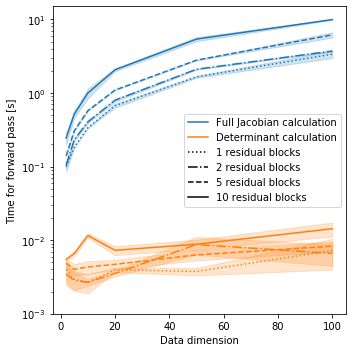

In [12]:
linestyles = [":", "-.", "--", "-"]
fig = plt.figure(figsize=(5,5))

for i, (block, ls) in enumerate(zip(blocks, linestyles)):
    plt.fill_between(xdims, jacobian_means[i] - jacobian_stds[i], jacobian_means[i]+jacobian_stds[i], color="C0", alpha=0.2)
    plt.plot(xdims, jacobian_means[i], c="C0", ls=ls)
    
    plt.fill_between(xdims, det_means[i] - det_stds[i], det_means[i]+det_stds[i], color="C1", alpha=0.2)
    plt.plot(xdims, det_means[i], c="C1", ls=ls)
    
plt.plot([], [], c="C0", ls="-", label="Full Jacobian calculation")
plt.plot([], [], c="C1", ls="-", label="Determinant calculation")
plt.plot([], [], c="black", ls=":", label="1 residual blocks")
plt.plot([], [], c="black", ls="-.", label="2 residual blocks")
plt.plot([], [], c="black", ls="--", label="5 residual blocks")
plt.plot([], [], c="black", ls="-", label="10 residual blocks")
plt.legend()

plt.xlabel("Data dimension")
plt.ylabel("Time for forward pass [s]")
plt.ylim(1.e-3,1.5e1)
plt.yscale("log")
# plt.ylim(0.,None)

plt.tight_layout()
plt.savefig("manifold_flow_timing_log.pdf")
